# Data processing

In this notebook, I am loading a list of molecules I obtained from ChEMBL and processing them to make sure I have:
- Standard SMILES representation of the compound
- InChIKey associated to the compound

In [1]:
# In this codeblock I will import the necessary packages and specify the paths to relevant folders

# %pip install rdkit
# %pip install standardiser
# %pip install ersilia

# uncomment the above in case of errors relating to rdkit, standardiser or ersilia not found

import csv
import time
import pandas as pd
import sys
sys.path.append('../src')
from smiles_processing import standardise_smiles
from ersilia import ErsiliaModel
import matplotlib.pyplot as plt


input_file = '../data/reference_library.csv'
output_folder = '../data/'

In [2]:
# In this codeblock I will load the data from the /data folder to a Pandas dataframe and understand which headers it has
df: pd.DataFrame = pd.read_csv(input_file)
df.columns

Index(['smiles'], dtype='object')

In [3]:
# In this codeblock I will convert the molecules to standard SMILES by using the function standardise_smiles from /src
# I will import the function directly from src, not copying it here

standard_smiles: list = standardise_smiles(df['smiles'])

[01:19:54] Can't kekulize mol.  Unkekulized atoms: 3 7


In [4]:
# In this codeblock I will get the Inchikey representation of the molecules using the RDKIT package
from rdkit import Chem

smiles_dict = {}

# convert SMILES to Molecule Objects then fetch Inchikey and save to a dictionary
for smiles in standard_smiles:
    # using a try except block to catch potential type error
    try:
        mol_object = Chem.MolFromSmiles(smiles)
    except TypeError as e:
        print(f"A TypeError occurred: {e}")
    else:
        inchikey = Chem.MolToInchiKey(mol_object)
        smiles_dict[inchikey] = smiles

A TypeError occurred: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t>> from this Python object of type float
A TypeError occurred: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t>> from this Python object of type float
A TypeError occurred: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t>> from this Python object of type float


In [5]:
# In this codeblock I will save the data as a .csv file containing only the standard smiles and the inchikey as columns.
# All data will be saved with informative names in the /data folder

df = pd.DataFrame(list(smiles_dict.items()), columns=['InChIKey', 'SMILES'] )

df.to_csv(output_folder + 'smiles_to_inchikeys_conversion.csv', index=False)

# Model Bias Evaluation

Now, I will use the predictions I got from the Ersilia Model Hub on the dataset of 1000 molecules curated above and see how are they distributed in their space (which might be 0 to 1 for probabilities, or different for regression models)

In [6]:
# In this codeblock I will load the chosen ersilia model and run the predictions using the Ersilia python library and save in the /data folder
start_time = time.time()

df = pd.read_csv(output_folder + 'smiles_to_inchikeys_conversion.csv')
smiles = df['SMILES']

model = ErsiliaModel("eos30gr")
model.serve()

predictions: list = list(model.run(smiles))

predictions_dict = {}

for prediction in predictions:
    smiles = prediction['input']['input']
    outcome = prediction['output']['outcome'][0]
    predictions_dict[smiles] = outcome

predictions_df = pd.DataFrame(list(predictions_dict.items()), columns=['smiles', 'prediction'])

predictions_df.to_csv(output_folder + 'predictions.csv', index=False)

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

Execution time: 89.02806878089905 seconds


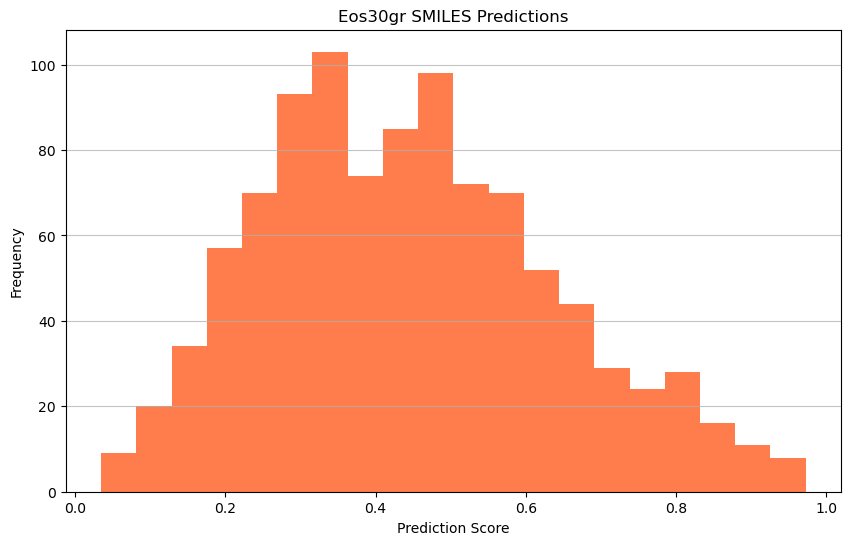

In [13]:
# In this codeblock I will create the necessary plots with MatPlotLib to observe the distribution of predicted values

df = pd.read_csv(output_folder + 'predictions.csv')


plt.figure(figsize=(10, 6))
plt.hist(df['prediction'], bins=20, color='orangered', alpha=0.7)
plt.title('Eos30gr SMILES Predictions')
plt.xlabel('Prediction Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()